# Session 5

In today's session we will learn about how to extract spectra from the MIRI IFU spectral cube, JWST. We will also identify emission lines.

This session will become the base of one of your projects. So take it seriously!!

## Spectral Cube

Unlike image that has 2 spatial axis, this has one spectral axis too. It can be in wavelength,frequency or velocity.

![Data Cube schematic.jpg](<attachment:Data Cube schematic.jpg>)
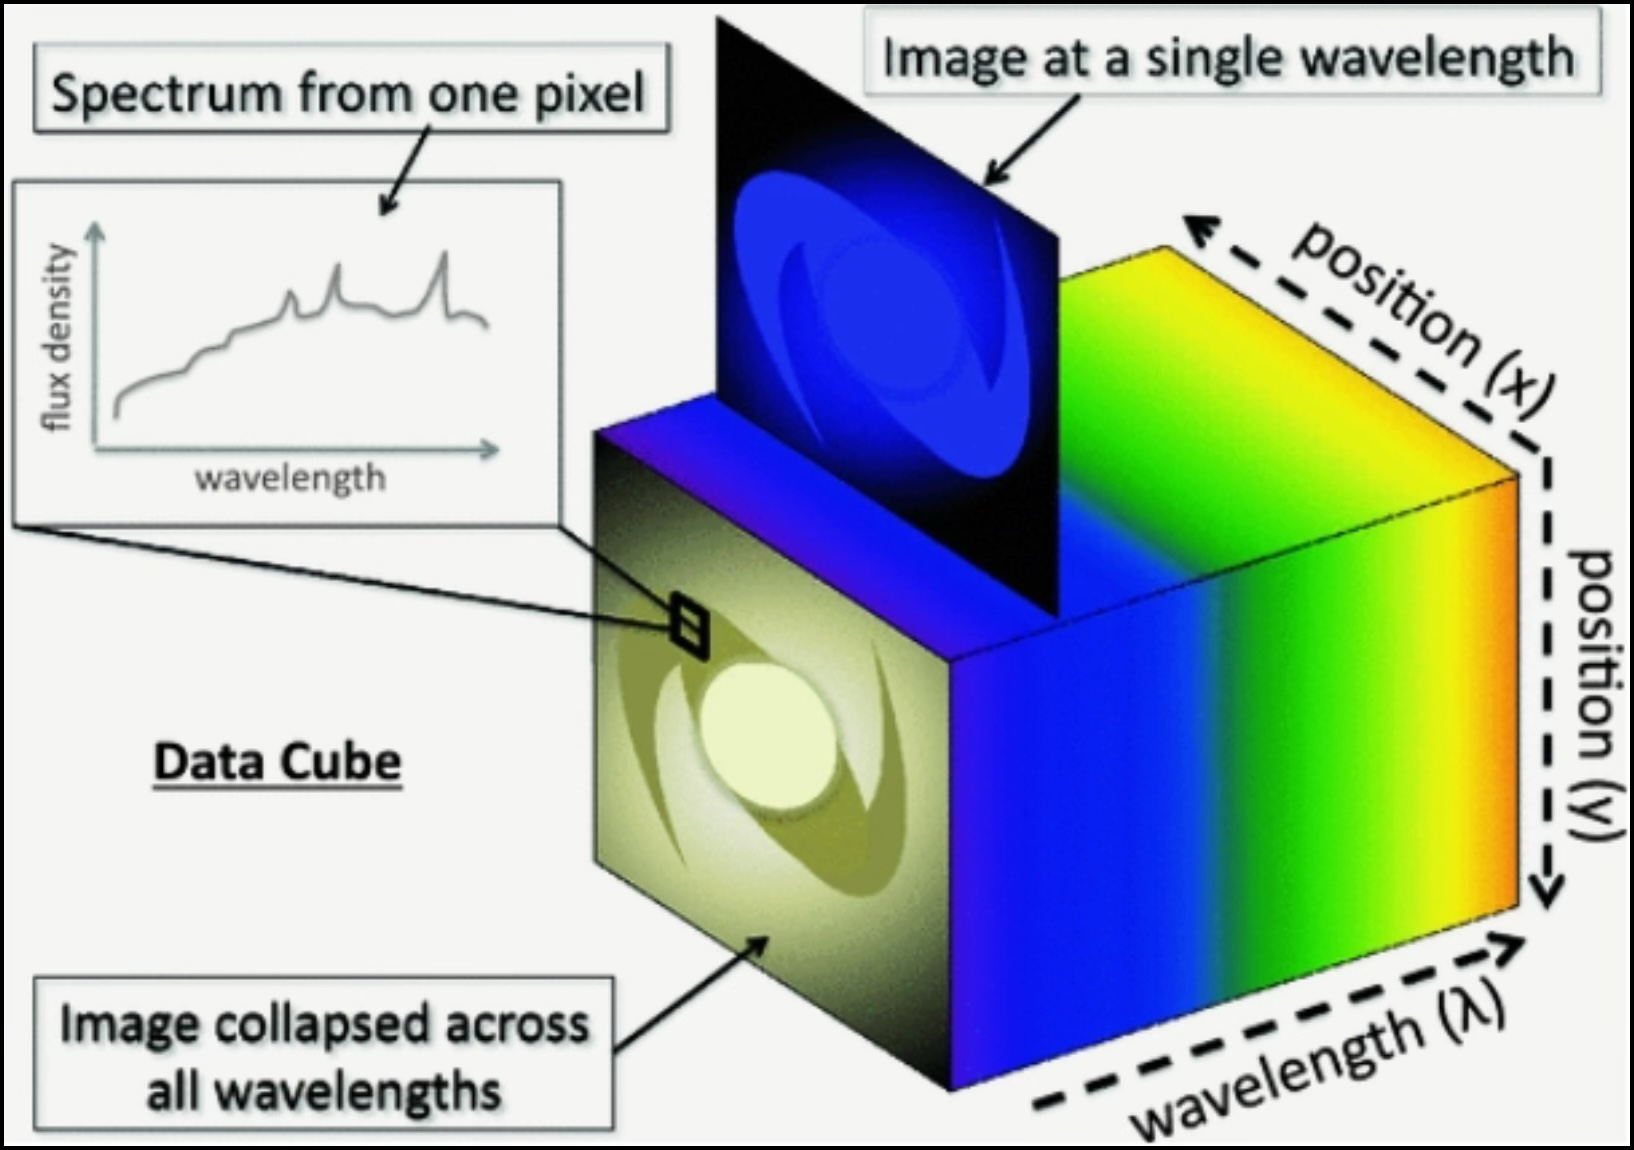

JWST has the following instruments:

1. NIRCam
2. NIRSpec
3. MIRI     --> We will use this today!

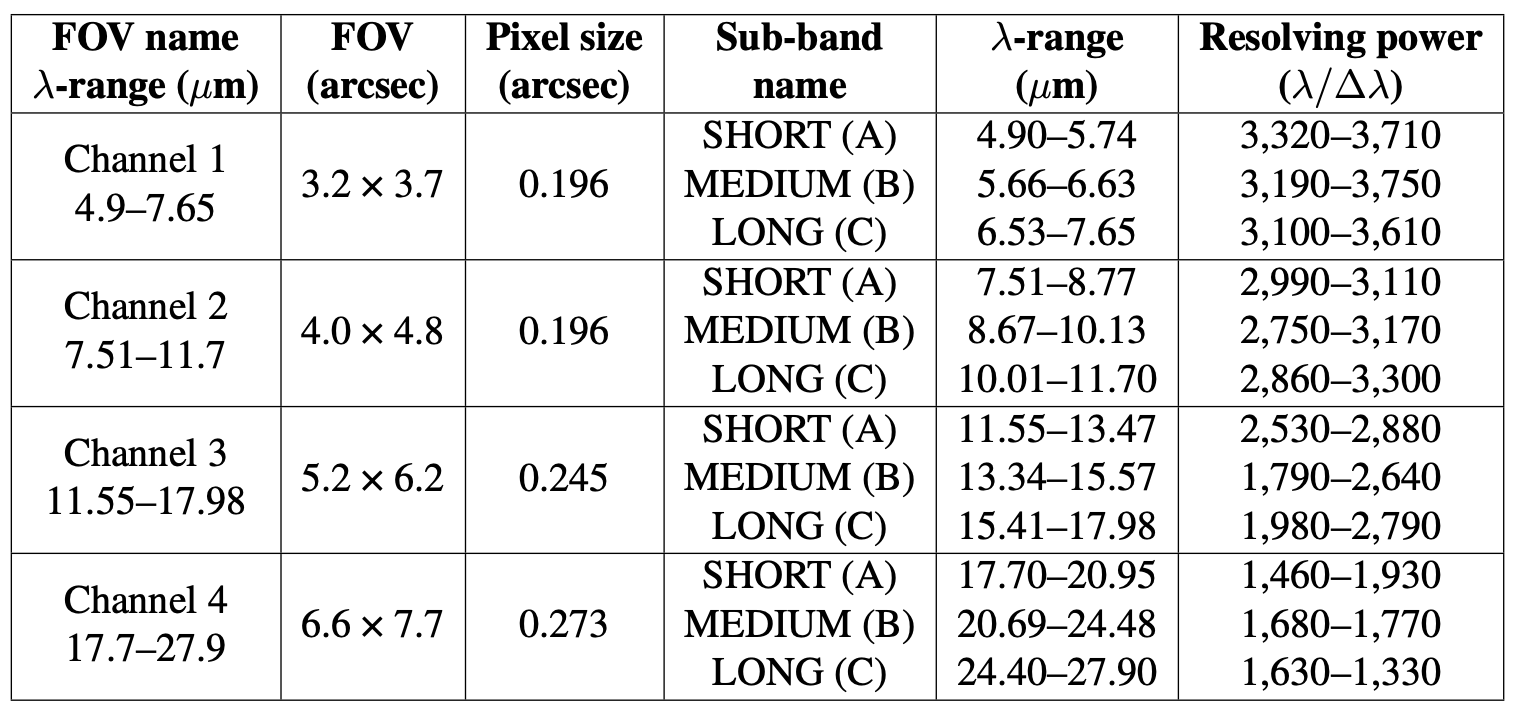

You can read more here: https://jwst-docs.stsci.edu/jwst-mid-infrared-instrument#gsc.tab=0

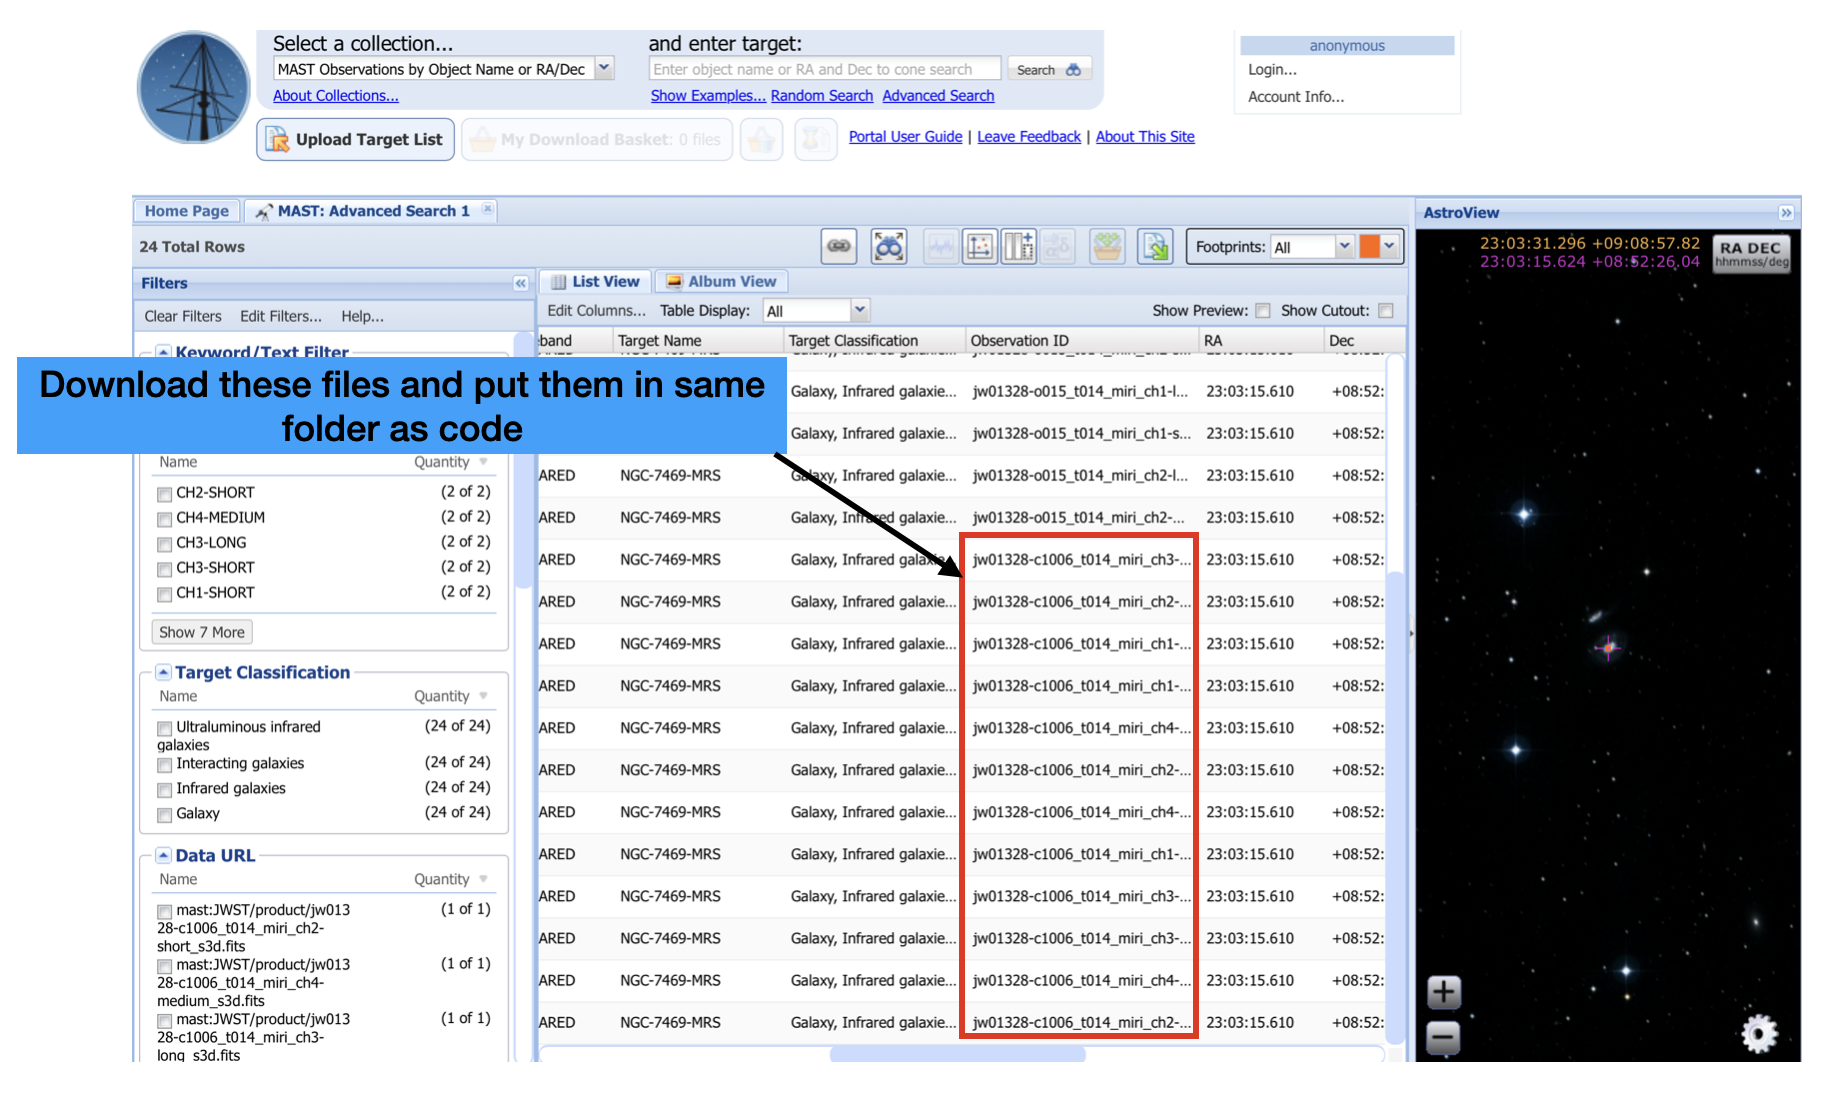

Make sure to download the -c1006 files because that means it is calibrated. These are level 3 files (_x3d.fits) i.e. science ready. Refer to the session 3 (exploring data archive session) to understand how to use MAST portal.

# regions

regions is an in-development coordinated package of Astropy for region handling.

The Regions package provides classes to represent:

    Regions defined using pixel coordinates (e.g., CirclePixelRegion)
    Regions defined using celestial coordinates, but still in an Euclidean geometry (e.g., CircleSkyRegion)
    To transform between sky and pixel regions, a world coordinate system object (e.g., astropy.wcs.WCS) is needed.

Regions also provides a unified interface for reading, writing, parsing, and serializing regions data in different formats, including the DS9 Region Format, CRTF (CASA Region Text Format), and FITS Region Binary Table format.

You can read more about it in here:

https://astropy-regions.readthedocs.io/en/stable/shapes.html

In [3]:
#Region-wise line plotting

# Import necessary libraries
import numpy as np
import warnings
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from regions import Regions

warnings.filterwarnings("ignore", category=UserWarning, append=True)

In [4]:
# Define the redshift for NGC 7469
# NGC 7469 is a Seyfert galaxy with a redshift of approximately 0.016268
# This value is used to convert observed wavelengths to rest-frame wavelengths
# The redshift value can be obtained from various astronomical databases like NED (NASA/IPAC Extragalactic Database)

z = 0.016268

reg_path = "region_file.reg" # From DS9 lecture, this is the region file containing the regions of interest
# Read the regions from the DS9 region file
# Make sure to have the regions file in the same directory as this script
regions = Regions.read(reg_path, format='ds9')


file_paths = []

# Only channel 2 for the session
for part in ['short','medium','long']:
        # I have kept them in a subfolder MAST_NGC_7469 for clarity
        # You can change the path as per your directory structure
        # The file names are based on the JWST data release naming convention
        file_paths.append(f'./MAST_NGC_7469/jw01328-c1006_t014_miri_ch{2}-{part}_s3d.fits')

# for ch_num in range(1,5):
#     for part in ['short','medium','long']:
#         file_paths.append(f'./MAST_NGC_7469/jw01328-c1006_t014_miri_ch{ch_num}-{part}_s3d.fits')

print(file_paths)

['./MAST_NGC_7469/jw01328-c1006_t014_miri_ch2-short_s3d.fits', './MAST_NGC_7469/jw01328-c1006_t014_miri_ch2-medium_s3d.fits', './MAST_NGC_7469/jw01328-c1006_t014_miri_ch2-long_s3d.fits']


Now we have defined the redshift from NED, made a region file from DS9 and made a list of all the files to iterate over. 

We can proceed further and extract the spectra from each of the file and plot the final spectrum from it.

In [5]:

# Loop over each region
for region in regions:  # For now we are only considering one region. In your project you can loop over all regions
    
    # Initialize lists to store the spectrum and wavelength for all channels

    spectrum_all = []
    spectrum_all_err = []
    wavelength_all = []

    for channel_index, file_path in enumerate(file_paths, start=1):
        
        # Initialize empty lists to store the spectrum and wavelength for this channel
        # This is done to store the spectrum and wavelength for each channel separately
        # This allows us to combine the spectra from all channels later
        spectrum = []
        spectrum_err = []

        # Get the mask for the region
        data = fits.open(file_path)[1].data       # 1 contain the 3D data cube
        data[data < 0] = np.nan
        data_err = fits.open(file_path)[2].data   # 2 contain the error cube

        # Open the FITS file and get the WCS information to make mask of the region
        # Mask means the region of interest in the image - other parts are ignored
        header = fits.open(file_path)[1].header
        wcs = WCS(header)
        mask = region.to_pixel(wcs.celestial).to_mask()  # Convert the region from celestial to pixel coordinates then make a mask
        # Get the shape of the data
        num_channels, ny, nx = data.shape

        # Loop over each channel (wavelength)
        for i in range(num_channels):
            # Extract the 2D image for the current channel
            masked_data = np.array(mask.multiply(data[i, :, :]), dtype=float)
            masked_data_err = np.array(mask.multiply(data_err[i, :, :]), dtype=float)

            avg_intensity = np.nanmean(masked_data)
            avg_intensity_err = np.sqrt(np.nanmean(masked_data_err**2))

            # Handle case where all values are NaN. To avoid RuntimeWarning: Mean of empty slice
            if np.isnan(avg_intensity):
                avg_intensity = 0
            if np.isnan(avg_intensity_err):
                avg_intensity_err = 0

            spectrum.append(avg_intensity)
            spectrum_err.append(avg_intensity_err)

        # Set up the wavelength axis
        n_wavelengths = data.shape[0]  # Number of wavelengths in the channel

        # Extract the WCS information from the header to get the wavelength values
        # CRVAL3, CDELT3, and CRPIX3 are WCS keywords that define the wavelength axis
    
        crval3 = header['CRVAL3']   # CRVAL3 is the reference value of the wavelength axis
        cdelt3 = header['CDELT3']   # CDELT3 is the increment in the wavelength axis
        crpix3 = header['CRPIX3']   # CRPIX3 is the reference pixel of the wavelength axis

        wavelength = (np.arange(n_wavelengths) - (crpix3 - 1)) * cdelt3 + crval3
        wavelength = wavelength / (1 + z) # Convert to rest-frame wavelength
        
        # Append the results for this channel to the overall lists
        # This is done to combine the spectra from all channels into one list
        # This allows us to plot the spectrum across all channels in one go
        # The wavelength and spectrum lists will have the same length
        
        wavelength_all.extend(wavelength)
        spectrum_all.extend(spectrum)
        spectrum_all_err.extend(spectrum_err)

        # Now you can add it to a dataframe. Explore pandas for this.


Set DATE-AVG to '2022-07-04T03:54:53.948' from MJD-AVG.
Set DATE-END to '2022-07-04T04:01:02.328' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -38.282938 from OBSGEO-[XYZ].
Set OBSGEO-H to 1737445736.637 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-07-04T04:11:31.595' from MJD-AVG.
Set DATE-END to '2022-07-04T04:17:33.047' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -38.283459 from OBSGEO-[XYZ].
Set OBSGEO-H to 1737461184.326 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-07-04T04:28:21.738' from MJD-AVG.
Set DATE-END to '2022-07-04T04:34:17.654' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -38.283980 from OBSGEO-[XYZ].
Set OBSGEO-H to 1737476718.880 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


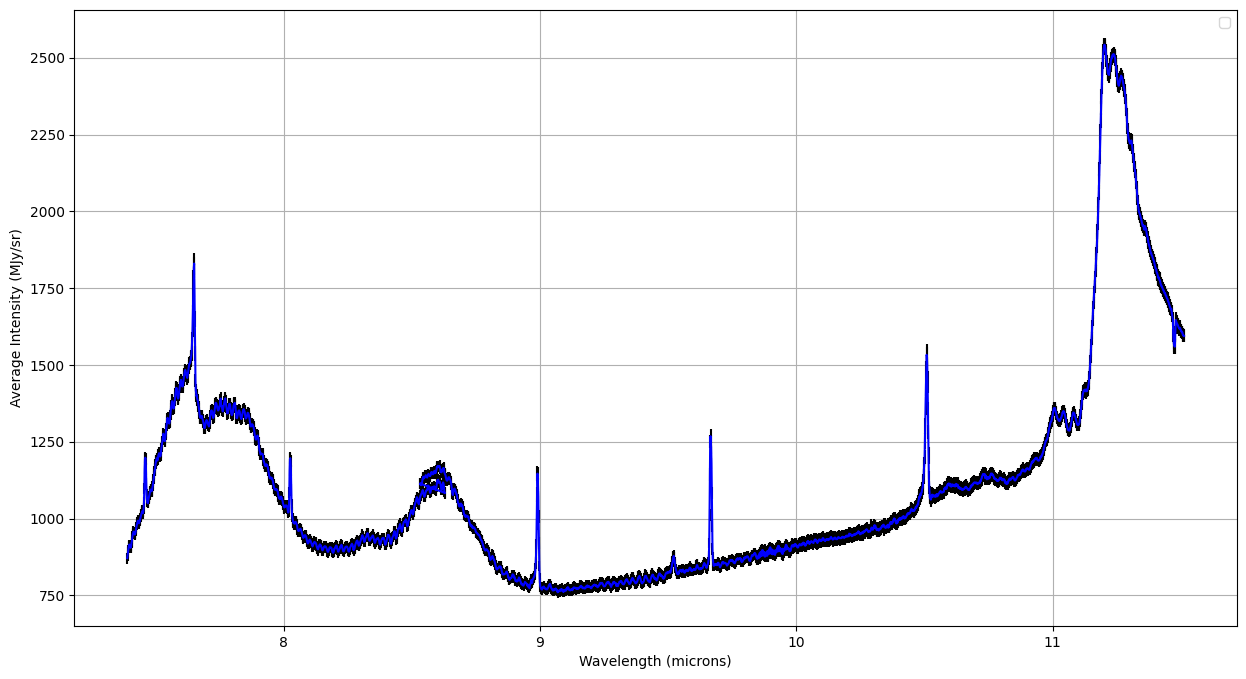

In [6]:
plt.figure(figsize=(15, 8))
plt.errorbar(wavelength_all, spectrum_all, yerr=spectrum_all_err, color='blue', ecolor='black')
plt.xlabel('Wavelength (microns)')
plt.ylabel('Average Intensity (MJy/sr)')

# Change the x-axis limits to focus on the desired region
# w_start, w_end = 8.95, 9.05
# plt.xlim(w_start, w_end)

# Auto-scale y-axis to the visible range
# plt.ylim(0, 1.1*np.nanmax(spectrum_all[(wavelength_all >= w_start) & (wavelength_all <= w_end)]))
plt.grid(True)
plt.legend()

In [ ]:
# %pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 3.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


The code below is to plot and interactively view the final spectra. It might be complex so you can treat it as a black box or explore on your own.

Your task here is to fill the spectral features by opening each file in cubeviz. I will give you an example walkthrough.

In [11]:
import plotly.graph_objects as go
import numpy as np

# Initialize figure with custom size
fig = go.Figure(layout=dict(
    width=800,  # Width in pixels
    height=500,  # Height in pixels
    template='plotly_white'
))

# Add spectrum trace
fig.add_trace(go.Scatter(
    x=wavelength_all,
    y=spectrum_all,
    mode='lines',
    line=dict(color='#1f77b4', width=1.5),
    name='Spectrum',
    hovertemplate='λ: %{x:.3f} μm<br>Intensity: %{y:.2f} MJy/sr<extra></extra>'
))

# Convert list to numpy
spectrum_all = np.array(spectrum_all)
spectrum_all_err = np.array(spectrum_all_err)

# Convert wavelength list to numpy
wavelength_all = np.array(wavelength_all)

# Add error band
fig.add_trace(go.Scatter(
    x=np.concatenate([wavelength_all, wavelength_all[::-1]]),
    y=np.concatenate([spectrum_all + spectrum_all_err, 
                     (spectrum_all - spectrum_all_err)[::-1]]),
    fill='toself',
    fillcolor='rgba(31, 119, 180, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo='skip',
    name='Uncertainty'
))

# Define all spectral features with different categories (edit here)
features = {
    'PAHs': {
         'PAH 7.7': 7.7, 'PAH 8.6': 8.6, 'PAH 11.3': 11.3,
    },
    'Iron': {
        
    },
    'Neon': {
         '[Ne VI]': 7.65,
    },
    'Other': {
         '[Ar III]': 8.991, 
        '[S IV]': 10.51
    },
    'H₂': {
         'S(3)': 9.66,
        'S(4)': 8.03
    }
}

# Add all features with different colors and styles
colors = {
    'PAHs': '#FF7F0E',  # Orange
    'Iron': '#2CA02C',  # Green
    'Neon': '#D62728',  # Red
    'Other': '#9467BD',  # Purple
    'H₂': '#8C564B'     # Brown
}

# Add vertical lines and annotations
for category, lines in features.items():
    for name, wl in lines.items():
        fig.add_vline(
            x=wl,
            line=dict(
                color=colors[category],
                width=1.5 if category == 'PAHs' else 1,
                dash='dot' if category != 'PAHs' else 'solid'
            ),
            annotation=dict(
                text=name,
                yanchor='bottom',
                font=dict(
                    size=10,
                    color=colors[category]
                ),
                yshift=10 if category == 'PAHs' else 0
            )
        )

# Highlight PAH bands with shaded regions
for wl in [ 7.7, 8.6, 11.3]:  # Add the PAH bands you want to highlight
    # Add a shaded rectangle for each PAH band
    # The rectangle is centered around the wavelength with a width of 0.3 microns
    fig.add_vrect(
        x0=wl-0.15, x1=wl+0.15,
        fillcolor=colors['PAHs'],
        opacity=0.1,
        line_width=0
    )

# Customize layout
fig.update_layout(
    # Title and axis labels
    title='<b>NGC 7469 JWST/MIRI IFU Spectrum with Molecular and Atomic Features</b>',
    xaxis_title='<b>Wavelength (μm)</b>',
    yaxis_title='<b>Intensity (MJy/sr)</b>',
    hovermode='x unified',                    # Unified hover mode for better interaction
    legend=dict(                              # Position the legend outside the plot area
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    ),
    margin=dict(l=50, r=50, b=50, t=80),      # Adjust margins for better spacing
)

fig.show()

## Using Cubeviz locally in your system

You can try installing jdaviz and do the analysis locally in your system. You can best use it in jupyter lab.

In [ ]:
# %pip install jdaviz

Note: you may need to restart the kernel to use updated packages.


In [ ]:
#Channel 3 opened in Cubeviz
from jdaviz import Cubeviz

cubeviz = Cubeviz()

# load the dataset:
cubeviz.load_data('./MAST_NGC_7469/jw01328-c1006_t014_miri_ch2-long_s3d.fits')  # Give the path to your FITS file here

# Show the Cubeviz interface
# You can interact with the data, plot spectra, and analyze the cube
# Note: Make sure you have the jdaviz package installed in your environment
cubeviz.show()

Application(config='cubeviz', docs_link='https://jdaviz.readthedocs.io/en/v4.2.1/cubeviz/index.html', events=[…